# Introduction to Deep Learning for Remote Sensing with Pytorch

*HFT Stuttgart, RSS, 2024 Summer Term, Michael Mommert (michael.mommert@hft-stuttgart.de)*

This notebook serves as a tutorial for how to use Pytorch for Deep Learning in a remote sensing setting. In this tutorial, we will introduce the supervised learning pipeline with the goal to train a Neural Network that performs climate zone classification based on Sentinel-2 imagery and Sentinel-1 SAR data. You can build upon the code presented in this tuturiol in your projects. Model architectures and datasets can be easily exchanged and modified. 

## Content

1. [Setting up the environment](#setup)
2. [Data Inspection](#data_inspection)
3. [Data Handling](#data)
4. [Model Implementation](#model)
5. [Training and Validation Pipeline](#train-val)
6. [Hyperparameter Tuning](#hyperpars)
7. [Evaluation](#evaluation)
8. [Inference](#inference)


<a id='setup'></a>
## 1. Setup

We're setting up our Python environment for this tutorial by installing and importing the necessary modules and packages:

In [5]:
# system level modules for handling files and file structures
import os
import tarfile
import copy

# scipy ecosystem imports for numerics, data handling and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch and helper modules
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18
from torchmetrics import Accuracy

# utils
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# rasterio for reading in satellite image data
try:
    import rasterio as rio
except ImportError:
    !pip install rasterio
    import rasterio as rio
from rasterio.enums import Resampling

We download the **ben-ge-800** dataset, if not yet present:

In [6]:
if not os.path.exists('ben-ge-800.tar.gz'):
    !gdown 1EDm4naHNhjUWSQRluV2VXHszKiNVc6B4

Downloading...
From (original): https://drive.google.com/uc?id=1EDm4naHNhjUWSQRluV2VXHszKiNVc6B4
From (redirected): https://drive.google.com/uc?id=1EDm4naHNhjUWSQRluV2VXHszKiNVc6B4&confirm=t&uuid=058876f6-15ae-4e04-af12-bf7b4954935a
To: /home/mommermi/hft/teaching/2024SoSe/RSS/lab/02_deeplearning/ben-ge-800.tar.gz
100%|████████████████████████████████████████| 183M/183M [00:06<00:00, 26.5MB/s]


**ben-ge-800** contains samples for 800 locations with co-located Sentinel-1 SAR data, Sentinel-2 multispectral data, elevation data, land-use/land-cover data, as well as environmental data. **ben-ge-800** is a subset of the much larger **ben-ge** dataset (see [https://github.com/HSG-AIML/ben-ge](https://github.com/HSG-AIML/ben-ge) for details.) We deliberately use a very small subset of **ben-ge** to enable reasonable runtimes for the examples shown in this tutorial.

We extract the `ben-ge-800.tar.gz` archive. To this end, we use the [tarfile](https://docs.python.org/3.6/library/tarfile.html) module from the Python standard library.

In [3]:
#tar_path = os.path.join('ben-ge-800.tar.gz')
data_base_path = os.path.abspath('.') 

#with tarfile.open(tar_path, mode='r') as tar:
#    tar.extractall(path=data_base_path)

data_base_path = os.path.join(data_base_path, 'ben-ge-800')

The environment is set up and the data in place. Before we define the dataset classes and dataloaders to access the data efficiently, we fix some random seeds to obtain reproduceable results:

In [4]:
np.random.seed(42)     # sets the seed value in Numpy
torch.manual_seed(42)  # sets the seed value in Pytorch

<a id='data_inspection'></a>
## 2. Data Inspection

Before we start implementing our model, let's have a look at the data. For this tutorial, we need three different data products that are available for every single sample in the dataset:
* Sentinel-2 multispectral data: 12-band Level-2A images of size 120x120; this will be first component of the model input data
* Sentinel-1 SAR polarization data: VH and VV polarization data of size 120x120; this will be second component of the model input data
* [ESAWorldCover](https://esa-worldcover.org/en) land-use/land-cover labels: for each sample, a value is provided that corresponds to the percentage at which each of XXX classes covers the map of this sample; in this tutorial, we will only consider the majority class and train a Neural Network that predicts this majority class from the input consisting of Sentinel-1 and Sentinel-2 data.

Let's have a look at how to access the different data products:

### Sentinel-2

Sentinel-2 data are located in the `ben-ge-800/sentinel-2/` directory. Each sample has its own subdirectory; random sample is named `S2B_MSIL2A_20170814T100029_90_11`. For each sample, 12 `.tif` files are available, one for each band. Let's open the red band data for this sample:

In [5]:
dataset = rio.open("ben-ge-800/sentinel-2/S2B_MSIL2A_20170814T100029_90_11/S2B_MSIL2A_20170814T100029_90_11_B04.tif")  # open tif file with rasterio
data = dataset.read(1)  # read data (band 1, since there is only one band)
data.shape, data.dtype

((120, 120), dtype('uint16'))

The data has indeed the shape 120x120 pixels (per band) and the data is stored as 16-bit integer values. Let's plot the data as a greyscale image:

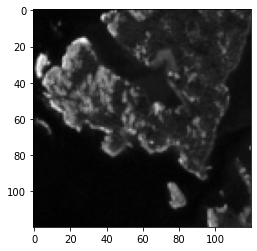

In [6]:
plt.imshow((data-np.min(data))/(np.max(data)-np.min(data)), cmap='Greys_r')

To plot a color image, we have to also open and read the blue and green bands. This is straightforward, since R, G, and B have the same spatial resolutions. Most other bands, however, have different spatial resolutions. Therefore, we have to resample the data to 10m resolution. Let's do this for all bands and then plot the true color information:

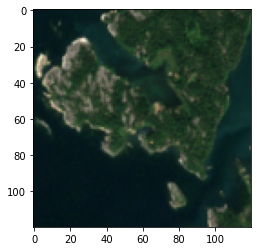

In [7]:
# an ordered list of all the bands to be extracted 
s2_bands = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B09", "B11", "B12", "B8A"]

# this dictionary describes the resampling factors between the individual bands
s2_resampling_factors = {"B01": 6, "B02": 1, "B03": 1, "B04": 1, "B05": 2, "B06": 2, "B07": 2, "B08": 1, "B09": 6, "B11": 2, "B12": 2, "B8A": 2}

# read all bands for one sample
img = np.empty((12, 120, 120))
for i, band in enumerate(s2_bands):
    upscale_factor = s2_resampling_factors[band]
    
    # read corresponding data file and upsample based on resampling factor
    with rio.open(f"ben-ge-800/sentinel-2/S2B_MSIL2A_20170814T100029_90_11/S2B_MSIL2A_20170814T100029_90_11_{band}.tif") as dataset:
                data = dataset.read(out_shape=(dataset.count, int(dataset.height * upscale_factor), int(dataset.width * upscale_factor)),
                                    resampling=Resampling.bilinear)  # we can resample the bands upon reading them
    img[i,:,:] = data

# plot the RGB information for that sample
img_rgb = np.dstack(img[1:4][::-1])  # extract RGB, reorder, and perform a deep stack (shape: 120, 120, 3)
plt.imshow((img_rgb-np.min(img_rgb))/(np.max(img_rgb)-np.min(img_rgb)))

In order to normalize our Sentinel-2 data, we simply divide the pixel values in each band by 10000 and clip the range from 0 to 1. This provides a reasonable value in each band:

In [8]:
np.average(np.clip(img/10000, 0, 1), axis=(1,2))

array([0.02313052, 0.0301817 , 0.03595887, 0.02285837, 0.04086418,
       0.09207724, 0.11021493, 0.11646207, 0.11610798, 0.06632351,
       0.03732942, 0.11904819])

### Sentinel-1

Reading Sentinel-1 data works very similar to Sentinel-2: data is stored in separate `.tif` files. Since both polarizations have the same spatial resolution, no resampling is necessary. Let's pick a random sample and plot its Sentinel-1 data:

Text(0.5, 1.0, 'VV')

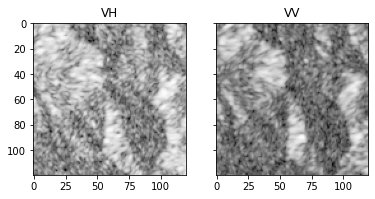

In [9]:
# an ordered list of all the bands to be extracted 
s1_bands = ["VH", "VV"]

# read all Sentinel-1 bands for a random sample
img = np.empty((2, 120, 120))
for i, band in enumerate(s1_bands):
    with rio.open(f"ben-ge-800/sentinel-1/S1B_IW_GRDH_1SDV_20180327T183408_29SNB_74_62/S1B_IW_GRDH_1SDV_20180327T183408_29SNB_74_62_{band}.tif") as dataset:
        data = dataset.read()
        img[i,:,:] = data

# plot both polarizations for that sample
f, ax = plt.subplots(1, 2, sharex=True, sharey=True)

ax[0].imshow((img[0]-np.min(img[0]))/(np.max(img[0])-np.min(img[0])), cmap='Greys_r')
ax[1].imshow((img[1]-np.min(img[1]))/(np.max(img[1])-np.min(img[1])), cmap='Greys_r')
ax[0].set_title('VH')
ax[1].set_title('VV')

We normalize our Sentinel-1 data by clipping the value provided, shifting and scaling them:

In [10]:
np.average((np.clip(img, a_min=-25, a_max=0) + 25) / 25, axis=(1,2))

array([0.36414841, 0.61240197])

### Land-use/land-cover data

Finally, we will read in the ESAWorldCover land-use/land-cover data. Since we are only interested in the coverage of each class, the data is stored in a simple `.csv` file. We can read this file with the Pandas module:

In [11]:
ewc_labels = pd.read_csv(f"ben-ge-800/ben-ge-800_esaworldcover.csv")
ewc_labels

,patch_id,filename,tree_cover,shrubland,grassland,cropland,built-up,bare/sparse_vegetation,snow_and_ice,permanent_water_bodies,herbaceous_wetland,mangroves,moss_and_lichen
0,S2B_MSIL2A_20180224T112109_61_46,S2B_MSIL2A_20180224T112109_61_46_esaworldcover...,0.1210,0.0553,0.7921,0.0307,0.0000,0.0009,0.0,0.0000,0.0000,0.0,0.0
1,S2B_MSIL2A_20170927T094019_14_89,S2B_MSIL2A_20170927T094019_14_89_esaworldcover...,0.6131,0.0000,0.2812,0.0733,0.0083,0.0000,0.0,0.0186,0.0054,0.0,0.0
2,S2A_MSIL2A_20170905T095031_2_30,S2A_MSIL2A_20170905T095031_2_30_esaworldcover.tif,0.8340,0.0000,0.0486,0.0604,0.0016,0.0318,0.0,0.0235,0.0001,0.0,0.0
3,S2B_MSIL2A_20171112T114339_33_73,S2B_MSIL2A_20171112T114339_33_73_esaworldcover...,0.0512,0.0000,0.6308,0.3097,0.0083,0.0000,0.0,0.0000,0.0000,0.0,0.0
4,S2B_MSIL2A_20170924T93021_33_2,S2B_MSIL2A_20170924T93021_33_2_esaworldcover.tif,0.9158,0.0000,0.0400,0.0001,0.0001,0.0000,0.0,0.0440,0.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,S2A_MSIL2A_20180205T100211_70_54,S2A_MSIL2A_20180205T100211_70_54_esaworldcover...,0.9531,0.0000,0.0464,0.0000,0.0000,0.0000,0.0,0.0005,0.0000,0.0,0.0
796,S2B_MSIL2A_20170817T101019_17_54,S2B_MSIL2A_20170817T101019_17_54_esaworldcover...,0.0008,0.0000,0.0705,0.0000,0.0001,0.0045,0.0,0.9240,0.0001,0.0,0.0
797,S2A_MSIL2A_20170813T112121_50_24,S2A_MSIL2A_20170813T112121_50_24_esaworldcover...,0.4863,0.0003,0.5094,0.0039,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0
798,S2A_MSIL2A_20170813T112121_9_82,S2A_MSIL2A_20170813T112121_9_82_esaworldcover.tif,0.0283,0.0016,0.1699,0.0437,0.6010,0.0381,0.0,0.1175,0.0000,0.0,0.0


We can display the coverage of each class across the entire dataset as a pie chart:

all classes:  Index(['tree_cover', 'shrubland', 'grassland', 'cropland', 'built-up',
       'bare/sparse_vegetation', 'snow_and_ice', 'permanent_water_bodies',
       'herbaceous_wetland', 'mangroves', 'moss_and_lichen'],
      dtype='object')


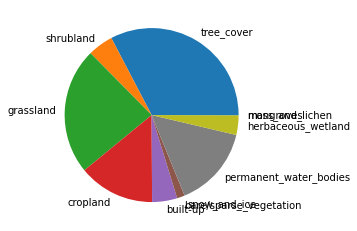

In [12]:
# we extract the different class labels
ewc_classes = ewc_labels.columns[2:]

# we sum up the coverages for each class
ewc_coverage = []
for c in ewc_classes:
    ewc_coverage.append(np.sum(ewc_labels.loc[:, c]))
ewc_coverage = np.array(ewc_coverage)/len(ewc_labels)

# plot coverages
plt.pie(ewc_coverage, labels=ewc_classes)
print('all classes: ', ewc_classes)

In our model training, we will use only the majority class. Let's derive the majority class and recreate the pie chart:

([<matplotlib.patches.Wedge at 0x7f7ee029b9d0>,
 [Text(0.448725308394928, 1.004313495680446, 'tree_cover'),
  Text(-0.8364466006196474, 0.7143928081327781, 'shrubland'),
  Text(-1.0913261653791653, -0.13786660494407957, 'grassland'),
  Text(-0.32344432920892574, -1.0513723250602462, 'cropland'),
  Text(0.29442471891887156, -1.0598651258011764, 'built-up'),
  Text(0.4565992983711179, -1.0007582528897792, 'bare/sparse_vegetation'),
  Text(0.4916765085342531, -0.9839990909322868, 'snow_and_ice'),
  Text(0.8822399961690405, -0.6570027314704647, 'permanent_water_bodies'),
  Text(1.0958974208516035, -0.09491492491069797, 'herbaceous_wetland'),
  Text(1.0999999999999974, 7.724207451134769e-08, 'mangroves'),
  Text(1.0999999999999974, 7.724207451134769e-08, 'moss_and_lichen')])

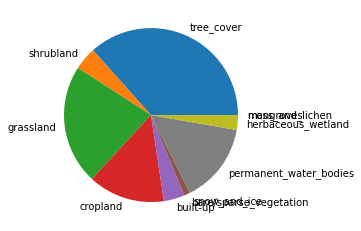

In [13]:
# derive the index of the majority class for each sample
ewc_major = np.argmax(ewc_labels.loc[:, 'tree_cover':].values, axis=1)

# redo pie chart with majority classes
plt.pie([np.sum(ewc_major == i) for i in range(len(ewc_classes))], labels=ewc_classes)

<a id='data'></a>
## 3. Data Handling

In the following, we implement a dataset class that combines the data access methods introduced above for the three data modalities. The dataset class provides easy and homogeneous access to the data on a per-sample basis. The `__getitem__` method returns a simple dictionary with the different data modalities that we use for data input and as target in the training and evaluation processes. As you will see later, the dataset class will be leveraged later by data loaders that will efficiently prepare data for the training pipeline.

As part of the dataset class, we apply data normalizations and output all numeric features as *Pytorch* tensors; tensors are the Pytorch equivalent of Numpy arrays but tensors can use GPU infrastructure for more efficient computations. Finally, we use predefined dataset splits: we can generate a training, validation and test dataset.

Please mind that we will use only those 4 bands from Sentinel-2 with a native resolution of 10~m (B, G, R, NIR). This is done to reduce the computational load and due to the fact that the other bands contribute only little information in this case.

In [14]:
class BENGE(Dataset):
    """A dataset class implementing the Sentinel-1, Sentinel-2 and ESAWorldCover data modalities."""
    def __init__(self, data_dir=None, split='train',
                 s2_bands=["B02", "B03", "B04", "B05"], s1_bands=["VH", "VV"]):
        """Dataset class constructor

        keyword arguments:
        data_dir -- string containing the path to the base directory of ben-ge dataset, default: ben-ge-800 directory
        split    -- string, describes the split to be instantiated, either `train`, `val` or `test`
        s2_bands -- list of Sentinel-2 bands to be extracted, default: all bands
        s1_bands -- list of Senintel-1 bands to be extracted, default: all bands

        returns:
        BENGE object
        """
        super(BENGE, self).__init__()

        # store some definitions
        if data_dir is None:
            self.data_dir = data_base_path
        else:
            self.data_dir = data_dir
        self.s2_bands = s2_bands
        self.s1_bands = s1_bands
        
        # read in relevant data files and definitions
        self.name = self.data_dir.split("/")[-1]
        self.split = split
        self.meta = pd.read_csv(f"{self.data_dir}/{self.name}_meta.csv")
        self.meta = self.meta.loc[self.meta.split == split, :]  # filter by split
        self.ewc_labels = pd.read_csv(f"{self.data_dir}/{self.name}_esaworldcover.csv")
        self.ewc_label_names = ["tree_cover", "shrubland", "grassland", "cropland", "built-up",
                                "bare/sparse_vegetation", "snow_and_ice","permanent_water_bodies",
                                "herbaceous_wetland", "mangroves","moss_and_lichen"]
        self.s2_resampling_factors = {"B01": 6, "B02": 1, "B03": 1, "B04": 1, "B05": 2, "B06": 2, "B07": 2, "B08": 1, "B09": 6, "B11": 2, "B12": 2, "B8A": 2}


    def __getitem__(self, idx):
        """Return sample `idx` as dictionary from the dataset."""
        sample_info = self.meta.iloc[idx]
        patch_id = sample_info.patch_id  # extract Sentinel-2 patch id 
        patch_id_s1 = sample_info.patch_id_s1  # extract Sentinel-1 patch id

        # retrieving Sentinel-2 data         
        s2 = self.load_s2(patch_id).astype(float)  # load Sentinel-2 data
        #s2 = np.moveaxis(s2, 0, -1)  # reordering data
        s2 = np.clip(s2 / 10000, 0, 1)  # normalize Sentinel-2 data

        # retrieving Sentinel-1 data
        if self.s1_bands:
            s1 = self.load_s1(patch_id_s1).astype(float)  # load Sentinel-1 data
            s1 = (np.clip(s1, a_min=-25, a_max=0) + 25) / 25
        else:
            s1 = None

        # extract top land-use/land-cover label 
        ewc_label = np.argmax(self.ewc_labels[self.ewc_labels.patch_id == patch_id][self.ewc_label_names])
        
        # create sample dictionary containing all the data
        sample = {
            "patch_id": patch_id,
            "s2": torch.from_numpy(s2).float(),
            "s1": torch.from_numpy(s1).float(),
            "lulc": torch.from_numpy(np.array([ewc_label.copy()], dtype=float)).long(),
            }

        return sample
        
    def __len__(self):
        """Return length of this dataset."""
        return self.meta.shape[0]

    def load_s2(self, patch_id):
        """Helper function to load Sentinel-2 data for a given `patch_id`."""
        img = []

        for band in self.s2_bands:
            upscale_factor = self.s2_resampling_factors.get(band)
            # read corresponding data file and upsample based on resampling factor
            with rio.open(f"{self.data_dir}/sentinel-2/{patch_id}/{patch_id}_{band}.tif") as d:
                data = d.read(
                out_shape=(
                    d.count,
                    int(d.height * upscale_factor),
                    int(d.width * upscale_factor)
                ),
                resampling=Resampling.bilinear
            )
            img.append(data)

        img = np.concatenate(img)
        return img
    
    def load_s1(self, s1_patch_id):
        """Helper function to load Sentinel-1 data for a given `patch_id`."""
        img = []

        for band in self.s1_bands:
            # read corresponding data file
            with rio.open(f"{self.data_dir}/sentinel-1/{s1_patch_id}/{s1_patch_id}_{band}.tif") as d:
                data = d.read()
                img.append(data)

        img = np.concatenate(img)
        return img
    
    def load_ewc(self, patch_id):
        """Helper function to load ESAWorldCover data for a given `patch_id`."""        
        with rio.open(f"{self.data_dir}/esaworldcover/{patch_id}_esaworldcover.tif") as d:
            data = d.read()

        return data
        

We can now instantiate the different splits for this dataset:

In [15]:
train_data = BENGE(split='train')
val_data = BENGE(split='val')
test_data = BENGE(split='test')

len(train_data), len(val_data), len(test_data)

(500, 150, 150)

We can retrieve a single sample simply by indexing:

In [16]:
train_data[12]

{'patch_id': 'S2B_MSIL2A_20180515T112109_86_61',
 's2': tensor([[[0.0382, 0.0352, 0.0363,  ..., 0.0265, 0.0317, 0.0333],
          [0.0374, 0.0356, 0.0343,  ..., 0.0276, 0.0305, 0.0327],
          [0.0312, 0.0306, 0.0295,  ..., 0.0295, 0.0301, 0.0310],
          ...,
          [0.0262, 0.0278, 0.0303,  ..., 0.0486, 0.0431, 0.0427],
          [0.0256, 0.0290, 0.0290,  ..., 0.0434, 0.0434, 0.0436],
          [0.0257, 0.0290, 0.0268,  ..., 0.0436, 0.0462, 0.0462]],
 
         [[0.0674, 0.0676, 0.0683,  ..., 0.0564, 0.0604, 0.0654],
          [0.0653, 0.0682, 0.0648,  ..., 0.0582, 0.0594, 0.0636],
          [0.0588, 0.0598, 0.0630,  ..., 0.0586, 0.0613, 0.0645],
          ...,
          [0.0673, 0.0720, 0.0782,  ..., 0.0828, 0.0798, 0.0800],
          [0.0612, 0.0614, 0.0685,  ..., 0.0782, 0.0800, 0.0823],
          [0.0593, 0.0601, 0.0640,  ..., 0.0785, 0.0784, 0.0837]],
 
         [[0.0750, 0.0695, 0.0719,  ..., 0.0462, 0.0571, 0.0602],
          [0.0773, 0.0729, 0.0662,  ..., 0.0495, 0.

For Neural Network training we have to define data loaders. When we do so, we have to define the batch size, which is typically limited by the GPU RAM during training. For evaluation purposes, we can typically pick a larger batch size, since we need less memory.

In [43]:
train_batchsize = 32
eval_batchsize = 64

train_dataloader = DataLoader(train_data, batch_size=train_batchsize, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=eval_batchsize, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=eval_batchsize, num_workers=4, pin_memory=True)

<a id='model'></a>
## 4. Model Implementation

In this tutorial, we will use a simple ResNet-18 model ([He et al. (2015)](https://arxiv.org/abs/1512.03385) to learn the task of patch-wise multi-class classification. This architecture is readily available through `torchvision`:

In [18]:
model = resnet18()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now, we have to change this model slightly to use it for our task:
* The model expects as input a tensor with 3 channels; our data, however, contains a total of 6 channels (4 channels from Sentinel-2 + 2 channels from Sentinel-1). Therefore, we have to replace the first convolutional layer to be able to use the 6 bands. Since we have to do this, we also change the kernel size to 3 to be more susceptible to small-scale features.
* The current model implementation generates a total of 1000 output features, since it is designed for a classification problem with 1000 different classes. Since our task only distinguishes between 12 different classes, we have to modify this output layer accordingly.

In [19]:
model.conv1 = nn.Conv2d(6, 64, kernel_size=3, stride=1, padding=1)
model.fc = nn.Linear(512, 12, bias=True)

This concludes our model implementation.

<a id='train-val'></a>
## 5. Training and Validation

First of all, let's verify if a GPU is available on our compute machine. If not, the CPU will be used instead.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Device used: {}'.format(device))

Device used: cpu


/home/mommermi/software/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Before we can implement the training pipeline we have to define two more things: a Loss function and an optimizer that will update our model weights during training. We also define our evaluation metric, for which we use the accuracy score.

In [21]:
# we will use the cross entropy loss
loss = nn.CrossEntropyLoss()

# we will use the Adam optimizer
learning_rate = 0.001
opt = optim.Adam(params=model.parameters(), lr=learning_rate)

# we instantiate the accuracy metric
accuracy = Accuracy(task="multiclass", num_classes=12)

Now, we have to move the model and the loss function on the GPU, since the computationally heavy work will be conducted there.

In [22]:
model.to(device)
loss.to(device)
accuracy.to(device)

MulticlassAccuracy()

Finally, we can implement our training pipeline. 


In [23]:
epochs = 5

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for ep in range(epochs):
    
    # we perform training for one epoch
    model.train()   # it is very important to put your model into training mode!
    for samples in tqdm(train_dataloader):
        # we extract the input data (Sentinel-1 and Sentinel-2)...
        s1 = samples['s1']
        s2 = samples['s2']
        # ... concatenate them along the channel axis and move them to the gpu
        x = torch.concat([s1, s2], dim=1).to(device)
        # x is of shape [batchsize, channels, height, width]

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].view(-1).to(device)

        # we make a prediction with our model
        output = model(x)

        # we reset the graph gradients
        model.zero_grad()

        # we determine the classification loss
        loss_val = loss(output, y)

        # we run a backward pass to comput the gradients
        loss_val.backward()

        # we update the network paramaters
        opt.step()

        # we write the mini-nbatch loss and accuracy into the corresponding lists
        train_losses.append(loss_val.detach().cpu())
        train_accs.append(accuracy(torch.argmax(output, dim=1), y).detach().cpu())

    # we evaluate the current state of the model on the validation dataset
    model.eval()   # it is very important to put your model into evaluation mode!
    with torch.no_grad():
        for samples in tqdm(val_dataloader):
            # we extract the input data (Sentinel-1 and Sentinel-2)...
            s1 = samples['s1']
            s2 = samples['s2']
            # ... concatenate them along the channel axis and move them to the gpu
            x = torch.concat([s1, s2], dim=1).to(device)
            # x is of shape [batchsize, channels, height, width]

            # now we extract the target (lulc class) and move it to the gpu
            y = samples['lulc'].view(-1).to(device)

            # we make a prediction with our model
            output = model(x)

            # we determine the classification loss
            loss_val = loss(output, y)

            # we write the mini-nbatch loss and accuracy into the corresponding lists
            val_losses.append(loss_val.detach().cpu())
            val_accs.append(accuracy(torch.argmax(output, dim=1), y).detach().cpu())
    
    print("epoch {}: train: loss={}, acc={}; val: loss={}, acc={}".format(
        ep, train_losses[-1], train_accs[-1], val_losses[-1], val_accs[-1]))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 0: train: loss=1.3047361373901367, acc=0.550000011920929; val: loss=2.531374931335449, acc=0.04545454680919647


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 1: train: loss=1.1647157669067383, acc=0.6499999761581421; val: loss=2.224632740020752, acc=0.3636363744735718


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 2: train: loss=1.0458406209945679, acc=0.6499999761581421; val: loss=1.1419581174850464, acc=0.6818181872367859


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 3: train: loss=0.7453289031982422, acc=0.75; val: loss=0.8299015164375305, acc=0.7727272510528564


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

epoch 4: train: loss=0.7236641049385071, acc=0.75; val: loss=0.8127296566963196, acc=0.6818181872367859


Training progress looks good: train and validation losses are decreasing, accuracies are increasing.

Let's plot the available metrics as a function of the number of training iterations:

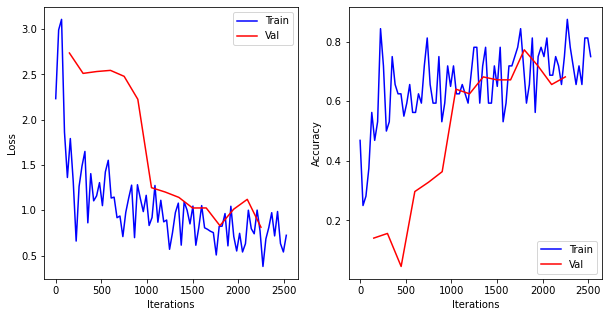

In [38]:
f, ax = plt.subplots(1, 2, sharex=True, figsize=(10,5))

ax[0].plot(np.arange(len(train_losses))*train_batchsize, train_losses, label='Train', color='blue')
ax[0].plot(np.arange(1, len(val_losses)+1)*len(val_data), val_losses, label='Val', color='red')
ax[0].set_xlabel('Iterations')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(np.arange(len(train_accs))*train_batchsize, train_accs, label='Train', color='blue')
ax[1].plot(np.arange(1, len(val_accs)+1)*len(val_data), val_accs, label='Val', color='red')
ax[1].set_xlabel('Iterations')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

We see how the losses drop and the accuracy increases for both the training and validation dataset. Since the validation metrics follow the training metrics, we do not see any obvious signs for overfitting. Based on the validation dataset, we reach an accuracy of 68% for our multi-class classification problem.

<a id='hyperpars'></a>
## 6. Hyperparameter Tuning

We trained the model successfully. But did we manage to get the best possible result? 

In order to find out, we have to perform hyperparameter tuning. The only obvious hyperparameter of our model is the learning rate. Architectural considerations can also be considered as hyperparameters, but we will keep our architecture fixed. 

As a result, we only have to tune the learning rate. We could try other learning rate values, such as 0.01 or 0.0001, or use a scheduler that modifies the learning rate as a function of the training progress.

However, we will skip this tuning process here to save some time. Instead, we will use the trained model ``as is''.



<a id='evaluation'></a>
## 7. Evaluation

After finishing the hyperparameter tuning, we can perform the final evaluation of our model. We will again use the accuracy metric, but could easily replace it or add additional metrics.

To properly evaluate our model we must use the test dataset in the evaluation process. Since the model has never seen the test dataset before, it will provide a realistic estimate of the performance of the model on previously unseen data.

The evaluation uses more or less the same code that we used to evaluate our model during training:

In [53]:
test_accs = []
predictions = []
groundtruths = []

model.eval()   # it is very important to put your model into evaluation mode!
with torch.no_grad():
    for samples in tqdm(test_dataloader):
        # we extract the input data (Sentinel-1 and Sentinel-2)...
        s1 = samples['s1']
        s2 = samples['s2']
        # ... concatenate them along the channel axis and move them to the gpu
        x = torch.concat([s1, s2], dim=1).to(device)
        # x is of shape [batchsize, channels, height, width]

        # now we extract the target (lulc class) and move it to the gpu
        y = samples['lulc'].view(-1).to(device)
        groundtruths.append(y.cpu())

        # we make a prediction with our model
        output = model(x)

        predictions.append(np.argmax(output.cpu().numpy(), axis=1))

        # we determine the classification loss
        loss_val = loss(output, y)

        # we write the mini-nbatch loss and accuracy into the corresponding lists
        test_accs.append(accuracy(torch.argmax(output, dim=1), y).cpu().numpy())

print('test dataset accuracy:', np.mean(test_accs))

# flatten predictions and groundtruths
predictions = np.concatenate(predictions).ravel()
groundtruths = np.concatenate(groundtruths).ravel()


  0%|          | 0/3 [00:00<?, ?it/s]

test dataset accuracy: 0.70596594


The test dataset accuracy is 70.5%, which is close to the validation accuracy - this is a good sign!

Now, let's also have a look at the performance on a per-class basis via the confusion matrix:

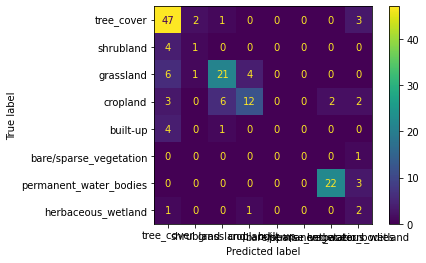

In [81]:
# create the confusion matrix
cm = confusion_matrix(groundtruths, predictions)

# plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=ewc_classes[np.unique(groundtruths)],
                              )
# note that not all classes are present in the test dataset

disp.plot()

Looking at the confusion matrix, it seems that the model does a fairly decent job at predicting the correct class for the largest classes. However, it seems unable to identify the small classes.

<a id='inference'></a>
## 8. Inference

Now that our model is trained and evaluated, we can use it to predict the most common land-use/land-cover class in an image patch.

Let's pick a random patch and run it through the model to perfom a prediction:

In [108]:
# we retrieve a random sample
sample = test_data[42]

# we prepare the Sentinel-1 and Sentinel-2 data for input into the model
input = torch.concat((sample['s1'], sample['s2']))

# we run the data through the model
output = model(input.view(1, 6, 120, 120))  # we have to change the shape of the input

# we identify that class with the strongest activation signal as our prediction
prediction = torch.argmax(output)

print('actual class:', ewc_classes[sample['lulc'].item()])
print('prediction:', ewc_classes[prediction.item()])

actual class: grassland
prediction: grassland
